In [20]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
from skimage.color import rgb2lab, lab2rgb
from tensorflow.keras.utils import plot_model
import os
import matplotlib.pyplot as plt
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, Reshape, BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU

The data that we are using for this project is from Kaggle. The dataset consist of street, buildings, mountains, glaciers, trees etc and their corresponding grayscale image in two different folders. This dataset was chosen as it has a wide range of textures, structures and colors. This diversity allows the model to learn how to handle different types of image data. Consequently it will perform good on this type of data only.

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("theblackmamba31/landscape-image-colorization")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/theblackmamba31/landscape-image-colorization/versions/4


In [8]:
print(os.listdir(f"{path}"))

['landscape Images']


In [9]:
images_path = f"{path}/landscape Images"

SIZE = 128
color_img = []

files_color = os.listdir(f"{images_path}/color")
for i in files_color:
    img = cv2.imread(f"{images_path}/color/{i}", 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                  # Converts the color format of the image from BGR to RGB.
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0                         # Normalizes the pixel values to a range of [0, 1]
    color_img.append(img_to_array(img))

gray_img = []
files_gray = os.listdir(f"{images_path}/gray")
for i in files_gray:
   img = cv2.imread(f"{images_path}/gray/{i}", 0)
   img = cv2.resize(img, (SIZE, SIZE))
   img = img.astype('float32') / 255.0
   gray_img.append(img_to_array(img))

print(len(color_img))
print(len(gray_img))

7129
7129


In [10]:
def plot_images(color, grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'red', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale, cmap='gray')

    plt.show()

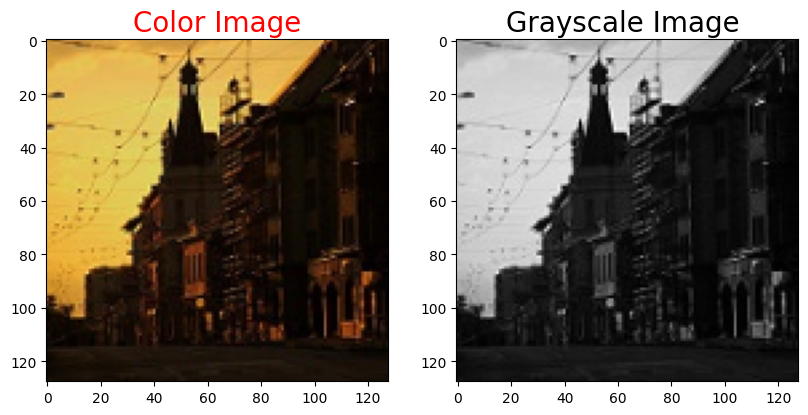

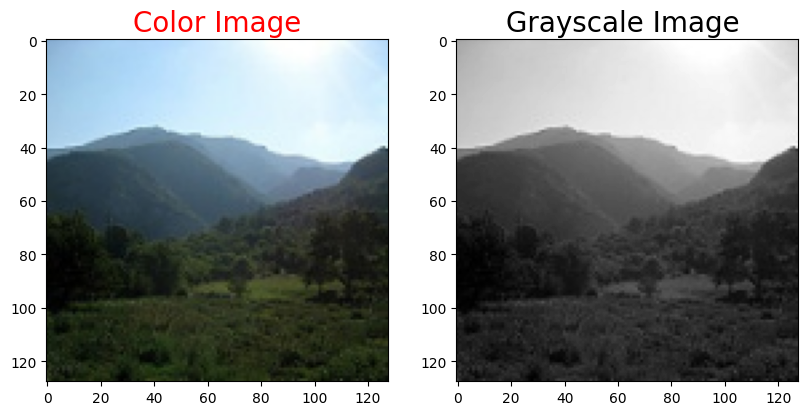

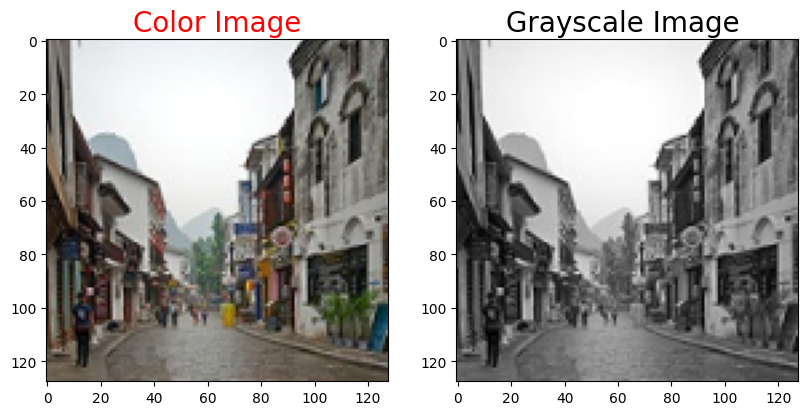

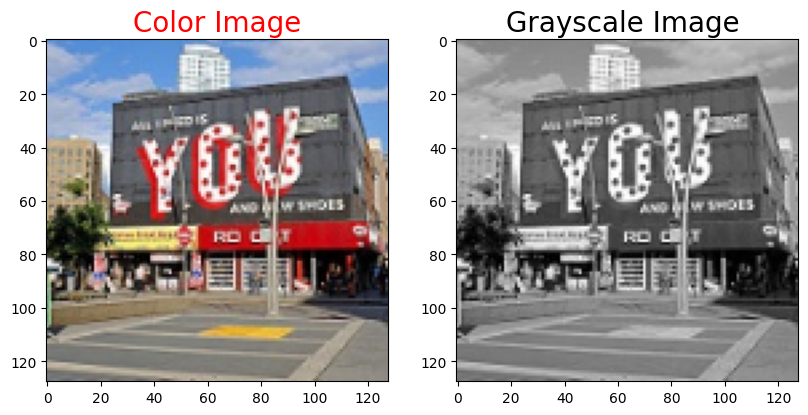

In [11]:
for i in range(1,5):
    plot_images(color_img[i], gray_img[i])

**LAB color space:**
- *L:* Lightness (grayscale information, ranging from black to white).
- *A:* Green-to-Magenta color channel.
- *B:* Blue-to-Yellow color channel.

Focuses on learning to predict A and B (chromaticity), as the L channel can be extracted directly from the grayscale image.
In RGB, brightness and color are interdependent, making it harder for the model to isolate color information.

Our final prediction looks like this. We have a grayscale layer for input, and we want to predict two color layers, the ab in Lab. To create the final color image we’ll include the L/grayscale image we used for the input.

In [12]:
color_img = np.array(color_img)

# Convert to LAB and split into x_data and y_data
x_data = []  # L channel
y_data = []  # A and B channels

for img in color_img:
    img_lab = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2LAB)
    L, A, B = cv2.split(img_lab)  # Split into channels

    # Normalize channels to [0, 1] (optional for LAB)
    L = L.astype('float32') / 255.0
    A = A.astype('float32') / 255.0
    B = B.astype('float32') / 255.0

    x_data.append(L)
    # Stack A and B channels and append to y_data
    y_data.append(np.stack((A, B), axis=-1))

# Convert to numpy arrays
x_data = np.array(x_data)  # Shape: (num_samples, SIZE, SIZE)
y_data = np.array(y_data)  # Shape: (num_samples, SIZE, SIZE, 2)

print(f"x_data shape: {x_data.shape}")
print(f"y_data shape: {y_data.shape}")

x_data shape: (7129, 128, 128)
y_data shape: (7129, 128, 128, 2)


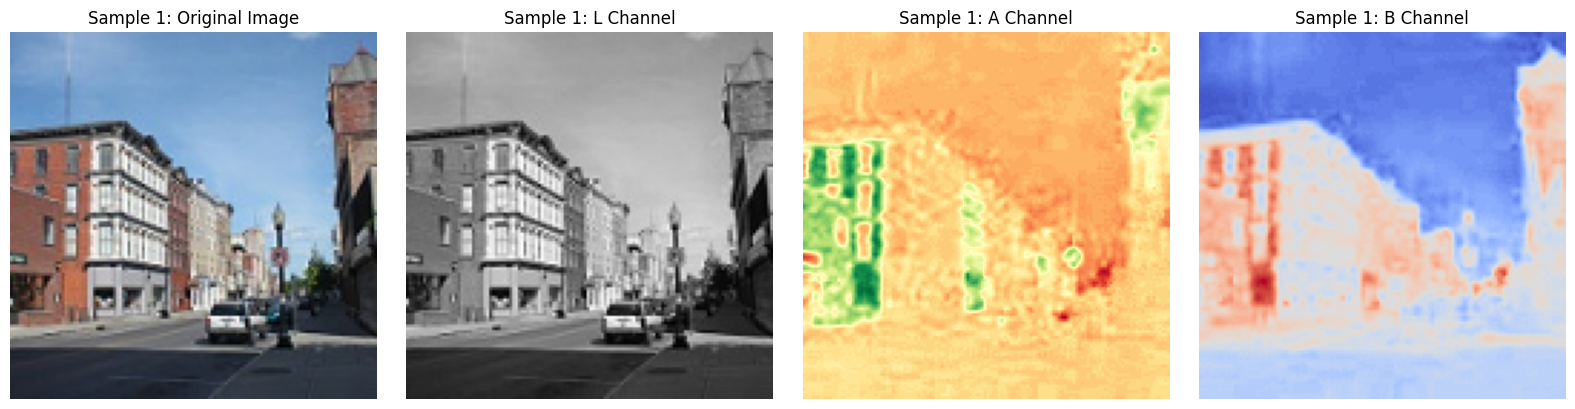

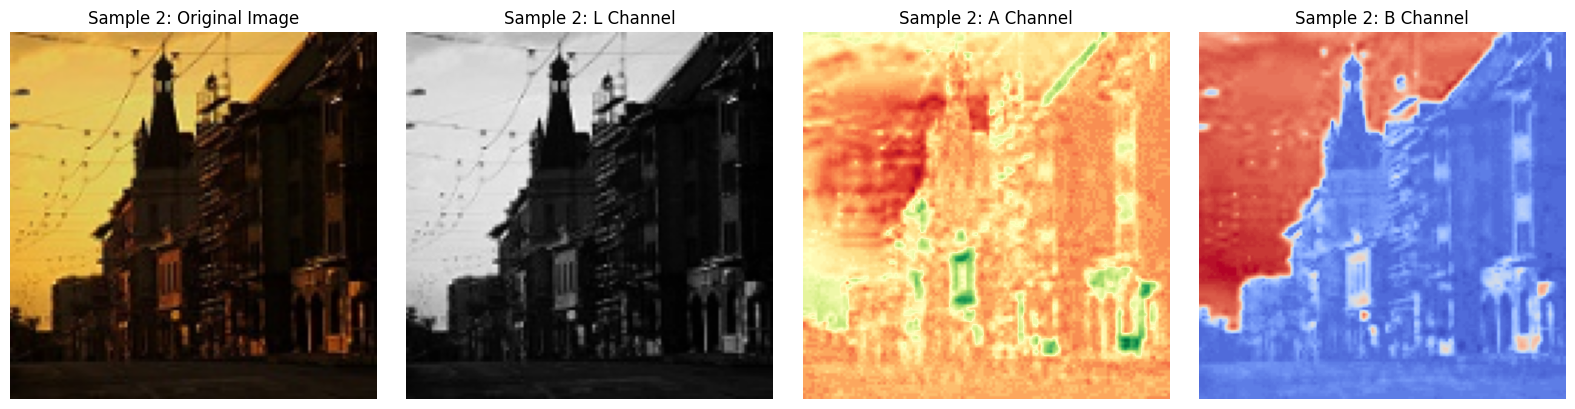

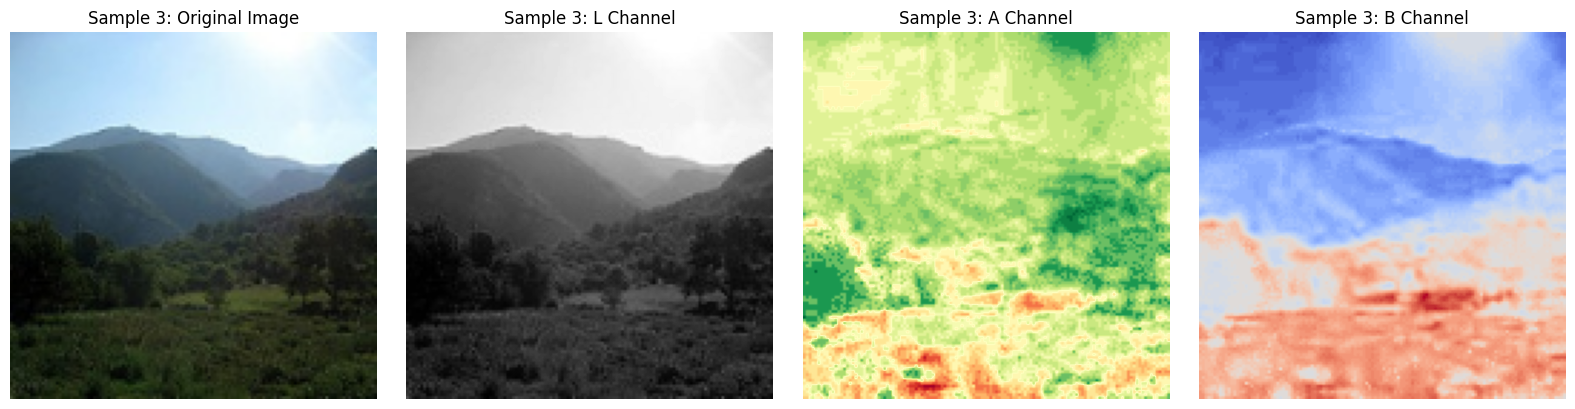

In [13]:
def visualize_lab_channels(color_img, x_data, y_data, num_samples=3):
    for i in range(num_samples):
        # Get L, A, B channels
        L_channel = x_data[i]
        A_channel = y_data[i, :, :, 0]
        B_channel = y_data[i, :, :, 1]
        original_img = color_img[i]

        plt.figure(figsize=(16, 4))

        plt.subplot(1, 4, 1)
        plt.title(f"Sample {i+1}: Original Image")
        plt.imshow(original_img)
        plt.axis('off')

        # Plot L channel
        plt.subplot(1, 4, 2)
        plt.title(f"Sample {i+1}: L Channel")
        plt.imshow(L_channel, cmap='gray')
        plt.axis('off')

        # Plot A channel
        plt.subplot(1, 4, 3)
        plt.title(f"Sample {i+1}: A Channel")
        plt.imshow(A_channel, cmap='RdYlGn') # colormap for green-to-red
        plt.axis('off')

        # Plot B channel
        plt.subplot(1, 4, 4)
        plt.title(f"Sample {i+1}: B Channel")
        plt.imshow(B_channel, cmap='coolwarm') # colormap for blue-to-yellow
        plt.axis('off')

        plt.tight_layout()
        plt.show()

visualize_lab_channels(color_img, x_data, y_data, num_samples=3)

In [14]:
train_gray_image = gray_img[:5700]
train_color_image = y_data[:5700]

valid_gray_image = gray_img[5700:-20]
valid_color_image = y_data[5700:-20]

test_gray_image = gray_img[-20:]
test_color_image = y_data[-20:]
test_orginal_image = color_img[-20:]

train_gray_image = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,1))
train_color_image = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,2))
print('Train gray image shape after:',train_gray_image.shape)
print('Train color image shape after:',train_color_image.shape)

valid_gray_image = np.reshape(valid_gray_image,(len(valid_gray_image),SIZE,SIZE,1))
valid_color_image = np.reshape(valid_color_image, (len(valid_color_image),SIZE,SIZE,2))
print('Valid gray image shape after:',valid_gray_image.shape)
print('Valid color image shape after:',valid_color_image.shape)

test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,1))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,2))
test_orginal_image = np.reshape(test_orginal_image, (len(test_orginal_image),SIZE,SIZE,3))
print('Test gray image shape after:',test_gray_image.shape)

Train gray image shape after: (5700, 128, 128, 1)
Train color image shape after: (5700, 128, 128, 2)
Valid gray image shape after: (1409, 128, 128, 1)
Valid color image shape after: (1409, 128, 128, 2)
Test gray image shape after: (20, 128, 128, 1)


The architecture of the autoencoder consists of two primary components: an encoder and a decoder, connected sequentially to learn the mapping from grayscale to color.

**Encoder :**
1. **Conv2D Layers with Strides=2:** effectively reduce the spatial dimensions of the feature maps. This downsampling is equivalent to pooling operations but is preferred because pooling layers discard pixel information, whereas Conv2D layers with strides learn meaningful features during the downsampling process. Each layer progressively extracts higher-level features from the grayscale input.

2. **Dropout Regularization:** A Dropout layer is included to prevent overfitting by randomly deactivating a fraction of neurons during training, ensuring the model generalizes better.

**Decoder :**
1. **Conv2DTranspose Layers:** upsample the feature maps back to the original spatial dimensions. Unlike simple upsampling layers, Conv2DTranspose layers learn weights for the upsampling process, which helps in reconstructing finer details of the colorized image.

2. **Final Output Layer:** The final Conv2D layer with a (2, 2) kernel and sigmoid activation generates the output with two channels (representing a and b channels in the LAB color space). The data has been normalized between 0 and 1, so the sigmoid activation ensures that the output values are bounded in this range.

**ReLU Activation:**

ReLU is applied to introduce non-linearity, allowing the model to capture complex relationships in the data. Although Leaky ReLU can handle cases where neurons "die," the experiments showed no significant difference, making ReLU a simpler and sufficient choice.

**Batch Normalization:**

The input and output data are already normalized so the batch normalization has not provided a noticeable performance boost.

**Other Architecture Choices:**

The **Adam optimizer** turned out to be the best choice for this problem. While AdamW and SGD were also tested, they did not perform as well, making Adam the most suit. The use of callbacks significantly improved the training process. **EarlyStopping** was implemented to monitor the validation loss, preventing overfitting and saving computation time. Additionally, the **ReduceLROnPlateau** callback dynamically adjusted the learning rate by reducing it when the validation loss has not improved, helping the model converge more effectively in later stages of training.

In [15]:
tf.random.set_seed(42)

encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, (3, 3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), strides=2, padding='same', activation='relu'),
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(2, (2, 2), activation='sigmoid', padding='same'),
])

optimizer = Adam(learning_rate=0.001)

autoencoder = tf.keras.Sequential([encoder, decoder])
autoencoder.compile(loss = "mae", optimizer = optimizer)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=3,
    min_lr=1e-6
)
callbacks=[early_stopping, lr_scheduler]

history = autoencoder.fit(train_gray_image, train_color_image, epochs = 100, batch_size = 128, validation_data = (valid_gray_image, valid_color_image), callbacks = callbacks)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 199ms/step - loss: 0.0361 - val_loss: 0.0348 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0345 - val_loss: 0.0335 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0336 - val_loss: 0.0327 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0329 - val_loss: 0.0315 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0322 - val_loss: 0.0314 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0319 - val_loss: 0.0309 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0316 - val_loss: 0.0308 - learning_rate: 0.0010
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0314 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0312 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 10

The performance metric used is MAE. The reason is:
- it directly evaluates the pixel-level error, telling us how accurately the model colored the pixels in the image
- it calcualtes the average of the absolute differences between the predicted values and the actual values, meaning it tells us how far off, on average, the predicted colos is from the actual color for each pixel.
- MAE is not very sensitive to outliers. In case we have pictures where some regions are more contrasted or more textured, we might have some color errors. MAE ensures that these errors are treated linearly(without exagerating larger errors more than smaller ones), so we have a more balanced measure of performance.

In [16]:
autoencoder.evaluate(test_gray_image,test_color_image)
encoder.summary()
decoder.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step - loss: 0.0287


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 387,840 (1.48 MB)

 Trainable params: 387,840 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 2)         │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 977,634 (3.73 MB)

 Trainable params: 977,634 (3.73 MB)

 Non-trainable params: 0 (0.00 B)

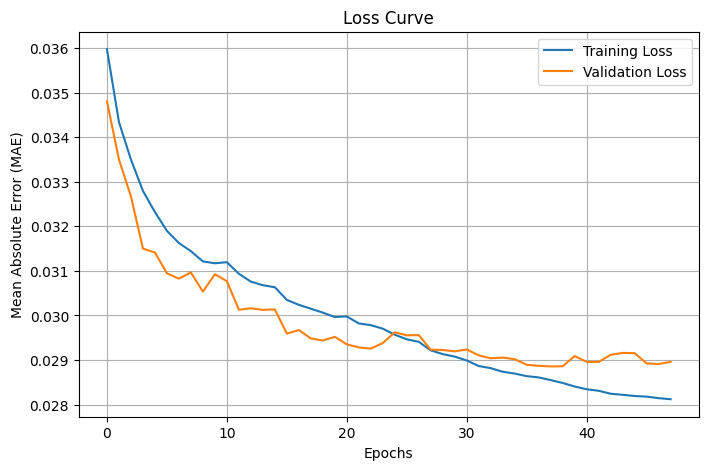

In [17]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()

**Before dropout:**
The blue line decreases steadily, indicating the model is effectively learning from the training data. The orange one initially decreases but drops significantly around 30 epochs, showing that the model's generalization to unseen data reaches a limit. The widening gap between the curves in later epochs indicates potential overfitting.

**With dropout**
This new loss curve reflects better training and generalization compared to the earlier version. The model now seems less prone to overfitting and demonstrates improved performance on the validation set. When the training and validation loss are close or overlap, it suggests that the model is performing equally well on both the training data and unseen validation data.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
(20, 128, 128, 2)


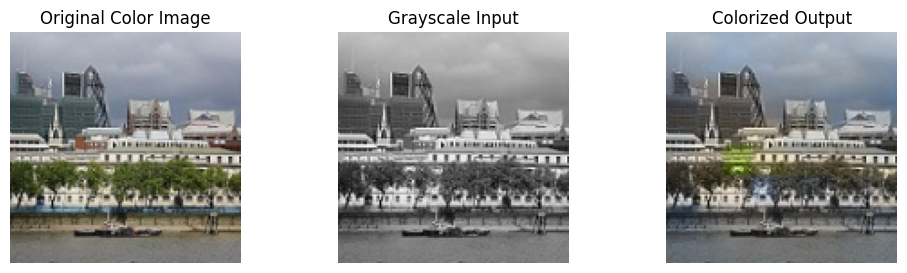

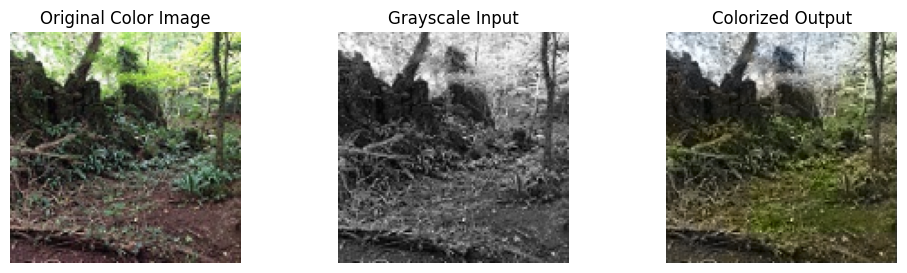

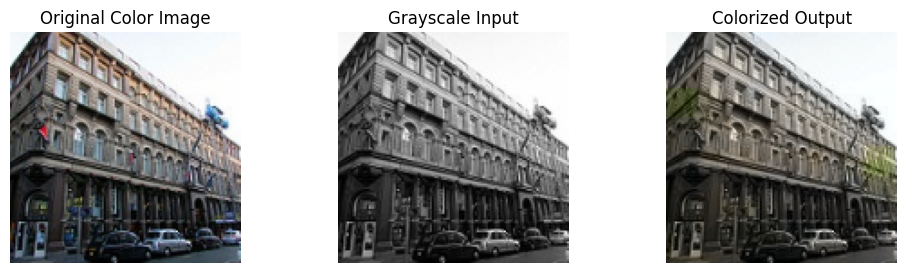

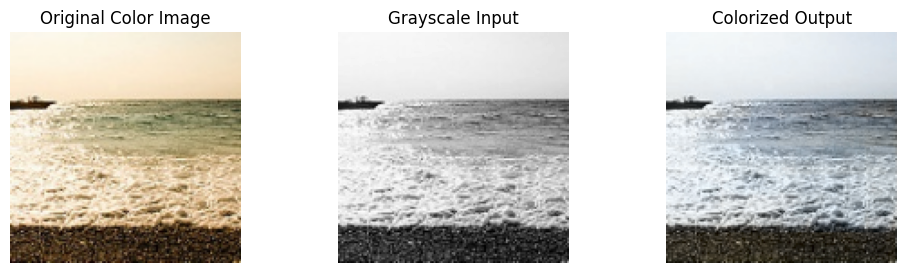

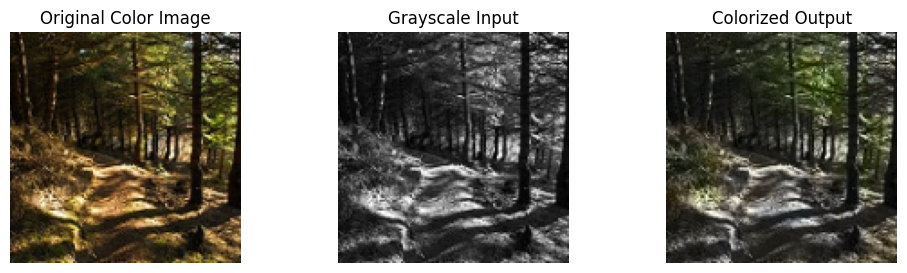

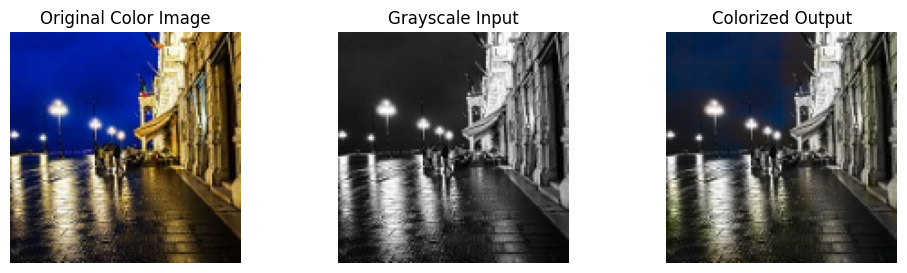

In [18]:
AB_images = autoencoder.predict(test_gray_image)
print(AB_images.shape)


def visualize_colorization(original, grayscale, AB_image, index):
    plt.figure(figsize=(12, 3))

    # Original colored image
    original = original[index]
    plt.subplot(1, 3, 1)
    plt.title("Original Color Image")
    plt.imshow(original)
    plt.axis('off')

    # Grayscale input image
    grayscale = grayscale[index]
    plt.subplot(1, 3, 2)
    plt.title("Grayscale Input")
    plt.imshow(grayscale, cmap='gray')
    plt.axis('off')

    # Colorized output from the model
    predicted_AB = AB_image[index]  # Scale back to [0, 255]

    # Combine L and predicted A, B channels to form LAB image
    grayscale = grayscale[ :, :, 0]
    LAB_image = np.zeros((128, 128, 3), dtype='float32')
    LAB_image[:, :, 0] = grayscale  # Add L channel
    LAB_image[:, :, 1:] = predicted_AB  # Add A and B channels

    # Convert LAB to RGB for visualization
    LAB_image = LAB_image * 255.0
    LAB_image = LAB_image.astype('uint8')
    colorized_image = cv2.cvtColor(LAB_image, cv2.COLOR_LAB2RGB)

    # Visualize the colorized image
    plt.subplot(1, 3, 3)
    plt.title("Colorized Output")
    plt.imshow(colorized_image)
    plt.axis('off')

    plt.show()

visualize_colorization(test_orginal_image, test_gray_image, AB_images, index=6)
visualize_colorization(test_orginal_image, test_gray_image, AB_images, index=8)
visualize_colorization(test_orginal_image, test_gray_image, AB_images, index=11)
visualize_colorization(test_orginal_image, test_gray_image, AB_images, index=13)
visualize_colorization(test_orginal_image, test_gray_image, AB_images, index=17)
visualize_colorization(test_orginal_image, test_gray_image, AB_images, index=3)

### Testing with external images


Testing image: /root/.cache/kagglehub/datasets/lprdosmil/unsplash-random-images-collection/versions/4/unsplash-images-collection/photo-1627562369418-e7ccfc3958c8.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


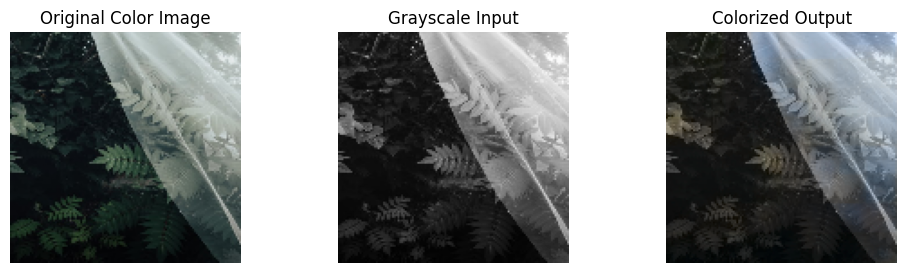

Testing image: /root/.cache/kagglehub/datasets/lprdosmil/unsplash-random-images-collection/versions/4/unsplash-images-collection/photo-1638103682270-0d1a4ab00b70.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


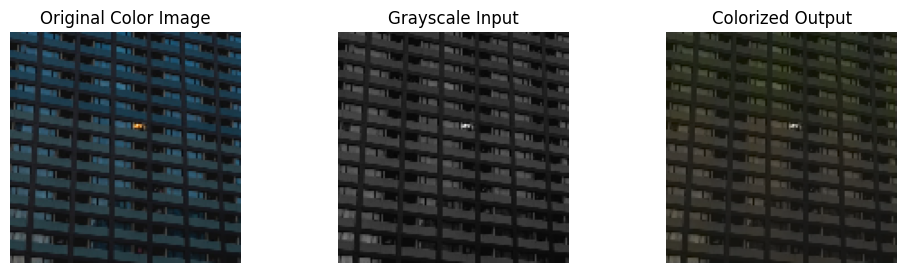

Testing image: /root/.cache/kagglehub/datasets/lprdosmil/unsplash-random-images-collection/versions/4/unsplash-images-collection/photo-1636017427762-5a8b1bd9f684.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


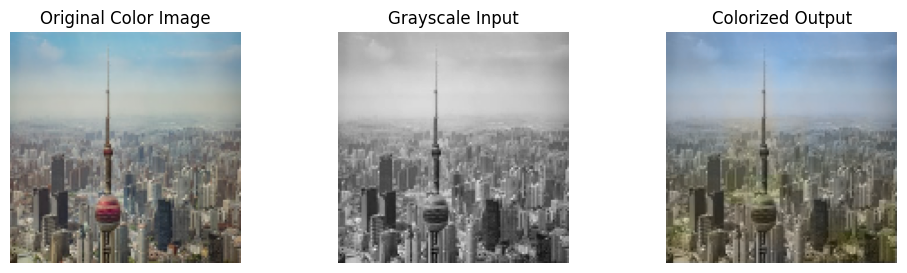

Testing image: /root/.cache/kagglehub/datasets/lprdosmil/unsplash-random-images-collection/versions/4/unsplash-images-collection/photo-1594118313797-0fe882874416.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


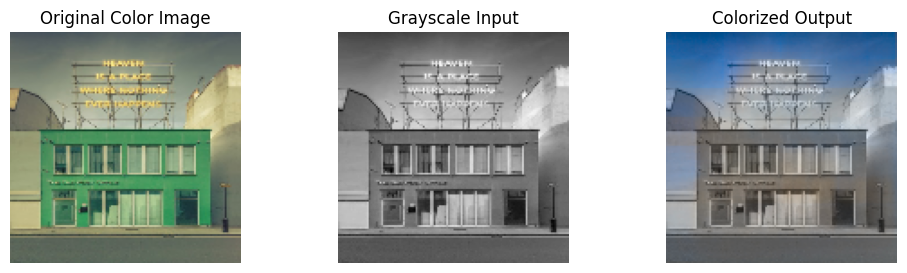

Testing image: /root/.cache/kagglehub/datasets/lprdosmil/unsplash-random-images-collection/versions/4/unsplash-images-collection/photo-1638063761285-08f6a2f796f5.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


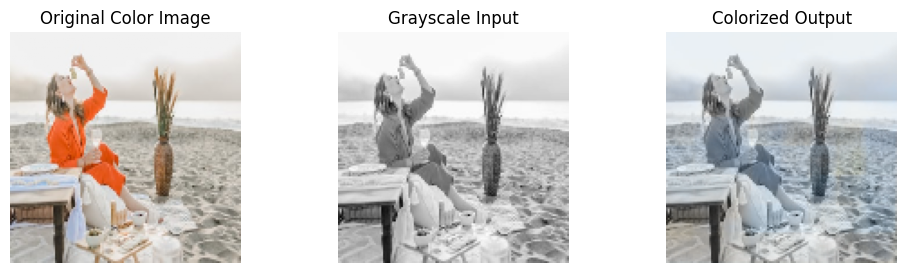

In [43]:
def get_random_images(dataset_path, n=5):
    all_files = []
    for root, _, files in os.walk(dataset_path):
        all_files.extend([os.path.join(root, file) for file in files if file.endswith(('png', 'jpg', 'jpeg'))])
    return random.sample(all_files, n)

def preprocess_image(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, target_size)

    grayscale_image = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)
    grayscale_image = grayscale_image / 255.0
    grayscale_image = np.expand_dims(grayscale_image, axis=-1)

    original_image = image_resized / 255.0

    return original_image, grayscale_image

def test_random_images_from_dataset(model, dataset_path, n=5, target_size=(128, 128)):
    random_image_paths = get_random_images(dataset_path, n)

    for image_path in random_image_paths:
        print(f"Testing image: {image_path}")
        original_image, grayscale_image = preprocess_image(image_path, target_size)

        grayscale_batch = np.expand_dims(grayscale_image, axis=0)

        AB_image = model.predict(grayscale_batch)

        visualize_colorization(
            original=np.array([original_image]),
            grayscale=np.array([grayscale_image]),
            AB_image=AB_image,
            index=0
        )


path = kagglehub.dataset_download("lprdosmil/unsplash-random-images-collection")

# Test the model on 5 random images
test_random_images_from_dataset(autoencoder, path, n=5)


**Conclusions**:
Our model performs well in colorizing landscape images, which is the dataset it is trained on. It achieved low and close to each other validation and tgraining losses. However, the model struggles when processing images containing people or unfamiliar objects, which is expected.If we were to improve on that we would need to train on a diverse dataset.